In [24]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Input, Dropout, Convolution2D, MaxPooling2D, Flatten
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix


In [13]:
PICTURE_SIZE = 32
CHANNELS = 'rgb'

INPUT_COLUMNS = []

for color in CHANNELS:
    INPUT_COLUMNS.extend(['%s%i' % (color, i)
                          for i in range(PICTURE_SIZE ** 2)])
old_column=list(range(0,PICTURE_SIZE*PICTURE_SIZE*3))

In [3]:
import cv2

def load_images(path):
    img_data = []
    labels = []
    idx_to_label = []
    i = -1
    for fruit in os.listdir(path):
        fruit_path = os.path.join(path,fruit)
        labels.append(fruit)
        i = i+1
        for img in os.listdir(fruit_path):
            img_path = os.path.join(fruit_path,img)
            image = cv2.imread(img_path)
            image = cv2.resize(image, (32, 32))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            img_data.append(image)
            idx_to_label.append(i)
    return np.array(img_data),np.array(idx_to_label),labels

In [4]:
training_data_path = '/home/fede/Documentos/Machine-learning/PT-1/data/Training'
validation_data_path = '/home/fede/Documentos/Machine-learning/PT-1/data/Validation'
X_train,y_train,label_data = load_images(training_data_path)
X_test,y_test,label_data_garbage = load_images(validation_data_path)

In [5]:
X_train[0].shape

(32, 32, 3)

In [6]:
train_rearmado=X_train.reshape(len(y_train),-1)#Rearma el array en dos dimensiones 

trainDF=pd.DataFrame(data=train_rearmado) 

etiqueta=pd.Series(data=y_train) #crea una serie con el index de las imagenes y el index de las etiquetas

etiqueta=etiqueta.replace({v: k for v, k in enumerate(label_data)},)#remplaza el index de las etiquetas con nombre de las mismas


trainDF['etiqueta']=etiqueta
print(trainDF.shape)

(33657, 3073)


In [7]:
trainDF.sample(5)

,0,1,2,3,4,5,6,7,8,9,...,3063,3064,3065,3066,3067,3068,3069,3070,3071,etiqueta
6970,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,Papaya
11061,254,255,255,255,255,255,254,254,254,255,...,255,255,255,255,255,255,255,255,255,Apple Red 1
28904,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,Mango
1969,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,Banana
20225,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,Pepino


In [8]:
test_rearmado=X_test.reshape(len(y_test),-1)#Rearma el array en dos dimensiones 

testDF=pd.DataFrame(data=test_rearmado) 

etiqueta=pd.Series(data=y_test) #crea una serie con el index de las imagenes y el index de las etiquetas

etiqueta=etiqueta.replace({v: k for v, k in enumerate(label_data)},)#remplaza el index de las etiquetas con nombre de las mismas


testDF['etiqueta']=etiqueta

In [14]:
def show_images(samples):
    for index, sample in samples.iterrows():

        sample_as_grid = sample[old_column].values.reshape(PICTURE_SIZE, PICTURE_SIZE, len(CHANNELS)).astype(np.float)
        sample_as_grid = sample_as_grid / 255
        
        plt.axis('off')
        plt.imshow(sample_as_grid, interpolation='nearest')

        plt.show()

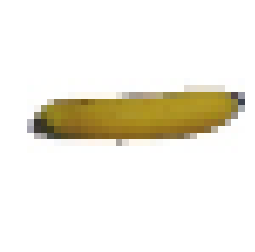

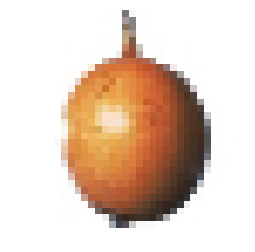

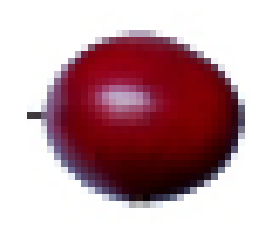

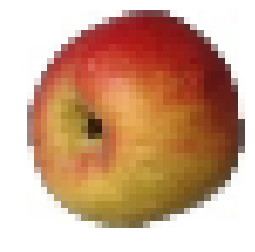

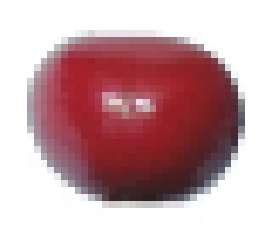

In [15]:
show_images(testDF.sample(5))

In [16]:
train = trainDF.copy()
test = testDF.copy()

sets = (
    ('train', train),
    ('test', test),
)

In [17]:
def extract_inputs(dataset):
    """
    Extrae del conjunto de datos original solo las 
    columnas que se deben utilizar como entrada. 
    """
    # estandarización rápida y simple: dividir todo por 255 :)
    #return dataset[INPUT_COLUMNS].values / 255
    return dataset[old_column].values.reshape(len(dataset), PICTURE_SIZE, PICTURE_SIZE, len(CHANNELS)) / 255


def extract_outputs(dataset):
    """
    Extrae del conjunto de datos original solo la 
    columna que se debe utilizar como salida y retorna
    tantas columnas como etiquetas distintas existan.
    Por ejemplo, podríamos pensar que las columnas resultantes
    serían: es_fisa, es_gabi, es_mariano.
    """
    is_fruit_columns = [(dataset.etiqueta == fruit).values for fruit in label_data]
    return np.array(is_fruit_columns).T

In [18]:
model = Sequential([
    #Dense(10, activation='tanh', input_shape=(len(INPUT_COLUMNS), )),
    Convolution2D(8, (4, 4), activation='relu', input_shape=(PICTURE_SIZE, PICTURE_SIZE, len(CHANNELS)),),
    Convolution2D(8, (4, 4), activation='relu'),
    MaxPooling2D(pool_size=(4, 4)),
    Dropout(0.2),
    Flatten(),
        
    Dense(10, activation='tanh'),
    Dropout(0.2),
    Dense(10, activation='tanh'),
    Dropout(0.2),

    Dense(len(label_data), activation='softmax'),
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',],
)

In [19]:
history = model.fit(
    extract_inputs(train), 
    extract_outputs(train), 
    epochs=5,
    batch_size=64,
    validation_data=(
        extract_inputs(test),
        extract_outputs(test),
    )
)

Train on 33657 samples, validate on 11312 samples
Epoch 1/5
33657/33657 [==============================] - 55s 2ms/step - loss: 3.6048 - acc: 0.0905 - val_loss: 3.0410 - val_acc: 0.1701
Epoch 2/5
33657/33657 [==============================] - 56s 2ms/step - loss: 2.8663 - acc: 0.1870 - val_loss: 2.4723 - val_acc: 0.2542
Epoch 3/5
33657/33657 [==============================] - 56s 2ms/step - loss: 2.5070 - acc: 0.2400 - val_loss: 2.1771 - val_acc: 0.3747
Epoch 4/5
33657/33657 [==============================] - 58s 2ms/step - loss: 2.3006 - acc: 0.2854 - val_loss: 1.9509 - val_acc: 0.4626
Epoch 5/5
33657/33657 [==============================] - 57s 2ms/step - loss: 2.1689 - acc: 0.3131 - val_loss: 1.8547 - val_acc: 0.4617


In [22]:
def add_predictions(dataset):

    predictions = model.predict(extract_inputs(dataset))

    for fruit_number, fruit in enumerate(label_data):
        dataset[fruit] = predictions[:, fruit_number]
    
    dataset['prediction'] = dataset[label_data].idxmax(axis=1)
    dataset['prediction_confidence'] = dataset[label_data].max(axis=1)
    dataset['correct'] = dataset.prediction == dataset.etiqueta

######################### train #########################
accuracy 0.5068187895534362


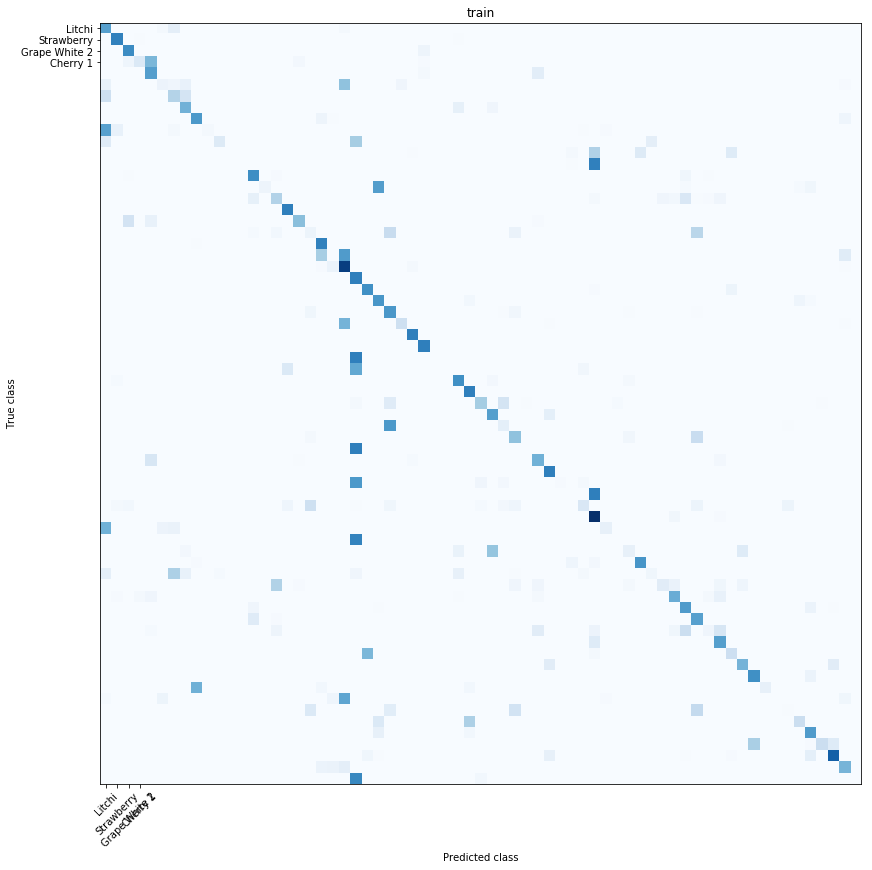

######################### test #########################
accuracy 0.4617220650636492


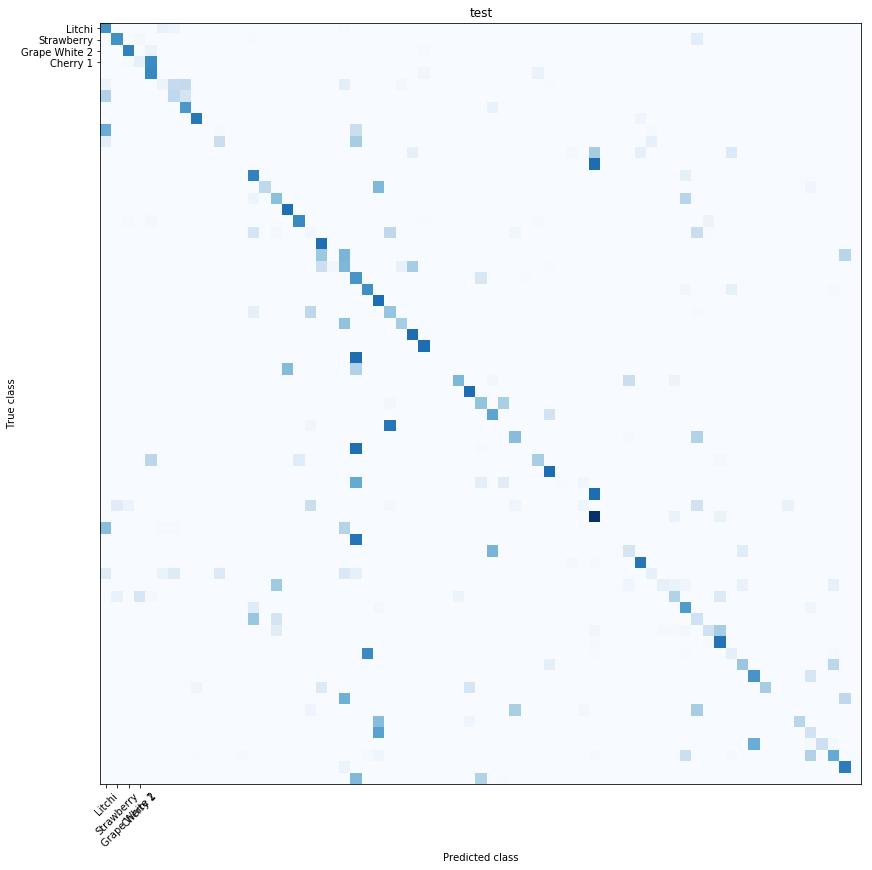

In [26]:
for set_name, set_data in sets:
    add_predictions(set_data)
    
    print('#' * 25, set_name, '#' * 25)
    print('accuracy', accuracy_score(set_data.etiqueta, set_data.prediction))

    # plot confussion matrix
        
    plt.figure(figsize=(15,14))
        
    plt.xticks([0, 1, 2, 3], label_data, rotation=45)
    plt.yticks([0, 1, 2, 3], label_data)
    plt.xlabel('Predicted class')
    plt.ylabel('True class')

    plt.title(set_name)

    plt.imshow(
        confusion_matrix(set_data.etiqueta, set_data.prediction), 
        cmap=plt.cm.Blues,
        interpolation='nearest',
    )

    plt.show()